# Speech Recognition using CDHMMs

In [18]:
import os
import MFCC
import re
import random
from glob import glob

import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statistics import mode

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [19]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    
    # Initialize state_arrays
    state_arrays = np.zeros(T)
    
    # Define the first part: Determine the hidden state X_t
    def find_state(t,memo):
        if t == 0:
            state_index = np.random.choice(len(pi), p = pi)
            memo[(t)] = state_index
            return state_index
        elif (t) in memo:
            return memo[(t)]
        else:
            # Do a recursive algorithm
            new_pi = A[:, memo[(t-1)]]
            state_index = np.random.choice(len(pi), p = pi)
            memo[(t)] = state_index
            return state_index
    
    # Get array of hidden states X_t
    memo = {}
    for t in range(T):
        state_arrays[t] = find_state(t,memo)
    
    # Define the second part function: Determine the GMM component
    def draw_categorial(x_index):
        weights_needed = weights[x_index]
        weight_index = np.random.choice(len(weights_needed), p = weights_needed)
        return weight_index
    
    # Determine gmm_components
    gmm_components_array = [draw_categorial(int(state)) for state in state_arrays]
    
    # Sample Z_t from the GMM by drawing from the normal distribution
    def draw_obs(state_index, component_index):
        mean = means[state_index, component_index, :]
        covariance = covars[state_index, component_index, :, :]
        observation = np.random.multivariate_normal(mean, covariance)
        return observation
    
    # Determine observation array
    obs_array = []
    for state,component in zip(state_arrays, gmm_components_array):
        obs = draw_obs(int(state), int(component))
        obs_array.append(obs)
        
    # Return state arrays and observations array
    return state_arrays, np.array(obs_array)
        
        
            
        
            
    
    

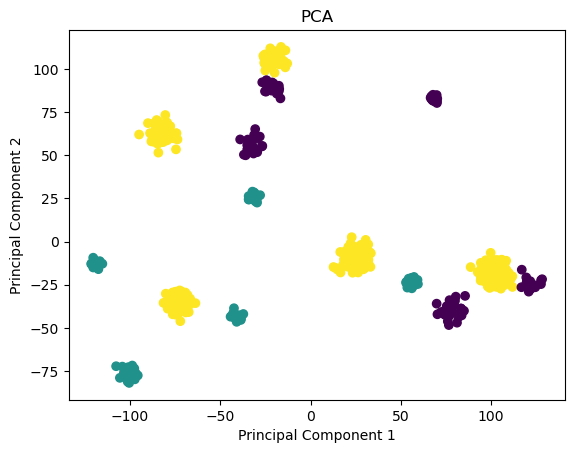

In [20]:
# Run sample_gmmhmm
states, observations = sample_gmmhmm(900)

# Run the fit_transform algorithm
pca = PCA(n_components = 2)
x = pca.fit_transform(observations)

# Plot the Principal Component Analysis
plt.scatter(x[:, 0], x[:,1], marker = 'o', c = states)
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()





## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [21]:
# Define the dictionary that stores the different vocabulary recordings
vocabulary_dict = {}

# Go through all filepaths and get the coefficients
for filepath in glob("Samples/*.wav"):
    course_name = os.path.basename(filepath).split(' ')[0]
    samplerate, sound_data = wavfile.read(filepath)
    coefficients = MFCC.extract(sound_data)
    if course_name not in vocabulary_dict:
        vocabulary_dict[course_name] = []
    vocabulary_dict[course_name].append(coefficients)



/var/folders/td/8px6smg12fxf4nw_rf4snx840000gn/T/ipykernel_71411/4273272837.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, sound_data = wavfile.read(filepath)


## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

In [22]:
from sklearn.model_selection import train_test_split

# Get the vocabulary words
keys = vocabulary_dict.keys()

# Initialize dictionaries
models = dict()
test_data_dict = dict()

# Go through all the different vocabulary values
for key in keys:
    max_log_likelihood = -1 * np.inf
    best_model = None
    
    # Get the MFCC data
    mfcc_data = vocabulary_dict[key]
    
    # Train-test split and store the test data into a dictionary
    train_data, test_data = train_test_split(mfcc_data, test_size = 10)
    test_data_dict[key] = test_data
    
    # Set up for getting log-likelihoods
    data_collected = np.vstack(train_data)
    lengths = [item.shape[0] for item in train_data]
    log_likelihood_array = []
    
    # Fit the data to get the log-likelihoods
    for _ in range(10):
        model = hmm.GMMHMM(n_components= 5, covariance_type= "diag")
        model.fit(data_collected, lengths = lengths)
        
        # Check the log_likelihood
        log_likelihood = model.monitor_.history[-1]
        
        # Get the best model
        if log_likelihood > max_log_likelihood:
            max_log_likelihood = log_likelihood
            best_model = model
            
    models[key] = best_model
    
            




    

{'Mathematics': GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0...
       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
       means_prior=array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
       n_components=5,
       weights_prior=array([[1.],
   

## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

In [28]:
# Define the different words
Words = ['Mathematics', 'Political Science', 'Biology',
         'Psychology', 'Statistics']

# Accept the MFCC coefficients of the speech sample to be predicted
def predict(coeffs):
    
    # Find the log probability density 
    log_likelihood_array = []
    for model in models.values():
        data_collected = coeffs
        log_likelihood = model.score(data_collected)
        log_likelihood_array.append(log_likelihood)
    
    # Return the word with the highest probability as the speech recognition model's prediction
    word_index = np.argmax(log_likelihood_array)
    return word_index

    
    
        
    
    

## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?

In [30]:
# Call your predict function on each sample
for i, key in enumerate(test_data_dict.keys()):
    accuracy_count = 0
    # Find proportion of each test set that your model predicts correctly
    for value in test_data_dict[key]:
        predicted_value = predict(value)
        if i == predicted_value:
            accuracy_count += 1
    print(f'{key} Accuracy is:')
    print(accuracy_count/len(test_data_dict[key]))
        



Mathematics Accuracy is:
1.0
PoliticalScience Accuracy is:
1.0
Biology Accuracy is:
0.8
Psychology Accuracy is:
1.0
Statistics Accuracy is:
1.0
